<a href="https://colab.research.google.com/github/Mateusfcs/Data-Science/blob/main/An%C3%A1lise_das_m%C3%A9tricas_RFV_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aluno: Mateus Fernandes Carneiro dos Santos**

** Contexto Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011. Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como: Clientes que compram os mesmos produtos; Clientes que possuem a mesma frequência de compras; Clientes que gastam mais dinheiro em suas compras. A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.**


# **Etapa 01) Análise exploratória dos dados**

a. Carregue a base de dados;

b. Realize uma descrição estatística dos dados;

c. Visualize as distribuições e identifique a relevância das colunas para a análise;

d. Verifique a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.


In [ ]:
%%capture
%pip install sidetable

In [ ]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html

# Padronizando os graficos

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

Etapas de Desenvolvimento

Etapa 01) Análise exploratória dos dados

a. Carregue a base de dados;

b. Realize uma descrição estatística dos dados;

c. Visualize as distribuições e identifique a relevância das colunas para a análise;

d. Verifique a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.

In [ ]:
#Entendendo o DataFrame
dados = pd.read_csv('data.csv', encoding='unicode_escape')
print(dados.shape)
dados.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
dados.info();
dados.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Analisando VAR categóricas
dados[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

<Axes: >

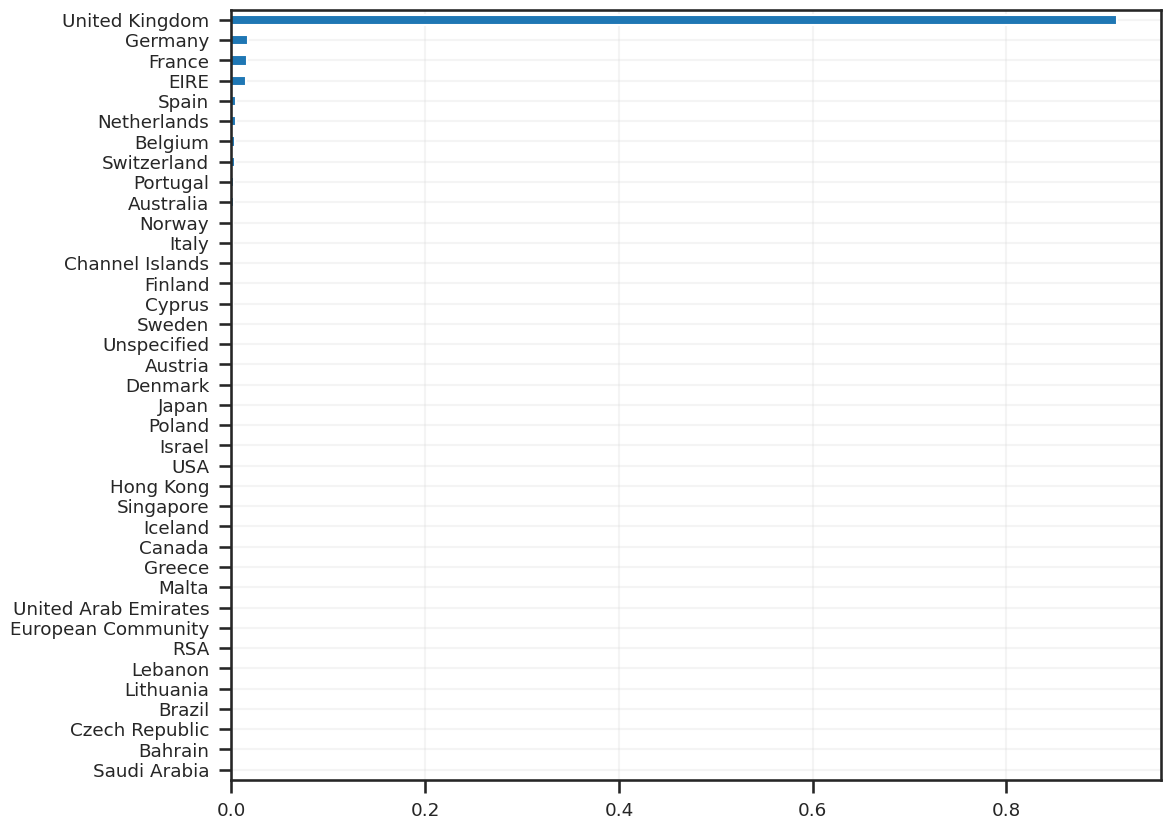

In [ ]:
# Analise de paises

dados['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

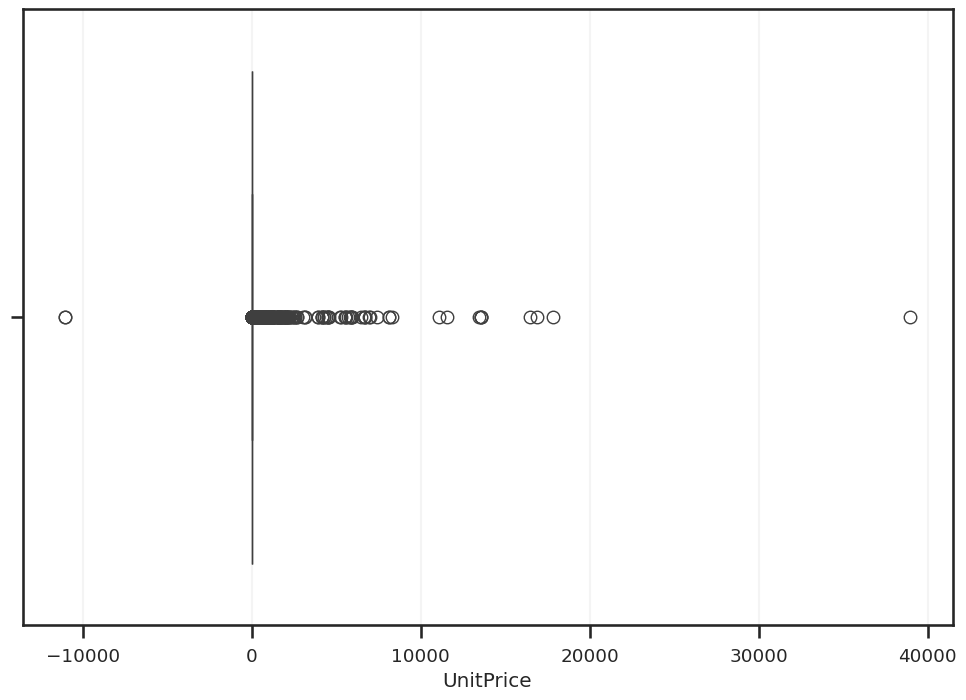

In [ ]:
# Identificando outliers
sns.boxplot(x=dados['UnitPrice'])
plt.show()

In [ ]:
dados[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
# Analisando a distribuicao por pais.

dados.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
# Observando nulos

dados.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [ ]:
# Observando duplicados

dados.duplicated().sum()

5268

# Etapa 02) Pré-processamento dos

a. Realize a normalização dos dados **negrito**

b. Faça uma seleção das variáveis mais relevantes para o modelo; **negrito**

c. Remova os dados nulos, duplicados, outliers e inconsistentes **negrito**

In [ ]:
dados.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [ ]:
#Dropnado os valores faltantes do ID por passarem de 30%, pode afetar o resultado.

df = dados.dropna(subset=['CustomerID'])

In [ ]:
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


# Organizando formado dos dados

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

<ipython-input-113-0a4a47e6cb3f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

<ipython-input-114-8861d7906295>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-8861d7906295>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Pegando a data Min e Max

df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [ ]:
# Removendo linhas de quantity e Price, onde temos valores negativos.
# Seria preciso ver com o time comercial, o que significa esses dados,
# troca, bonificacao, devolucao... como nao temos essa inf, vamos dropar.

below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

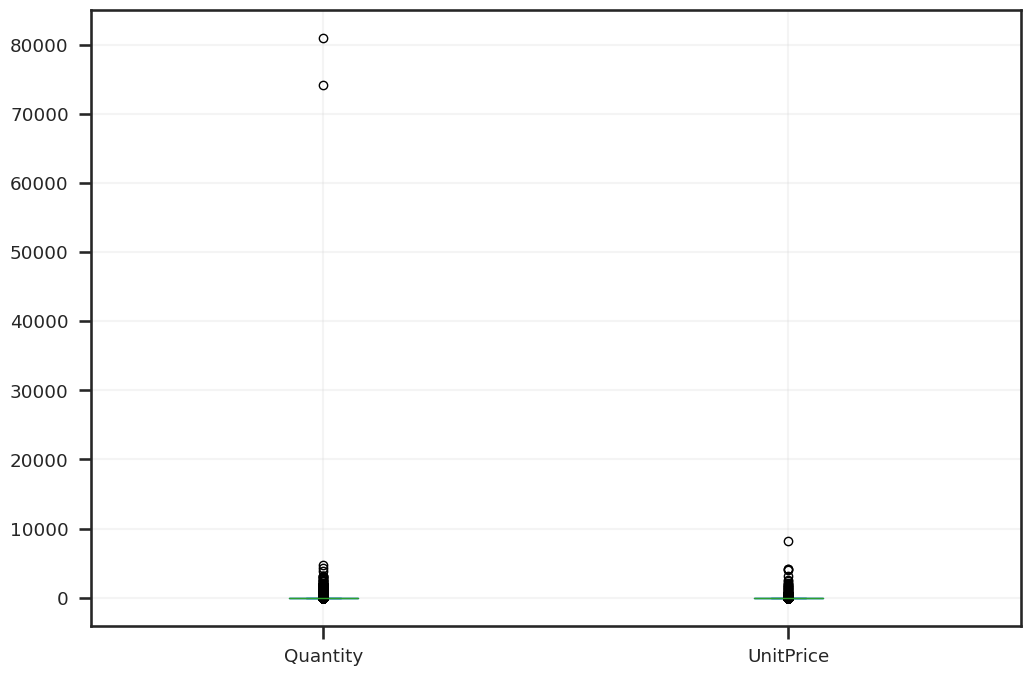

In [ ]:
#Verificando outliers

df[['Quantity','UnitPrice']].plot.box()

In [ ]:
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [ ]:
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [ ]:
# Add o valor total da compra por cliente

df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [ ]:
pd.Timestamp.today()

Timestamp('2024-01-17 18:50:51.549814')

In [ ]:
pd.Timestamp('2012-01-01')

Timestamp('2012-01-01 00:00:00')

In [ ]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)


<Axes: >

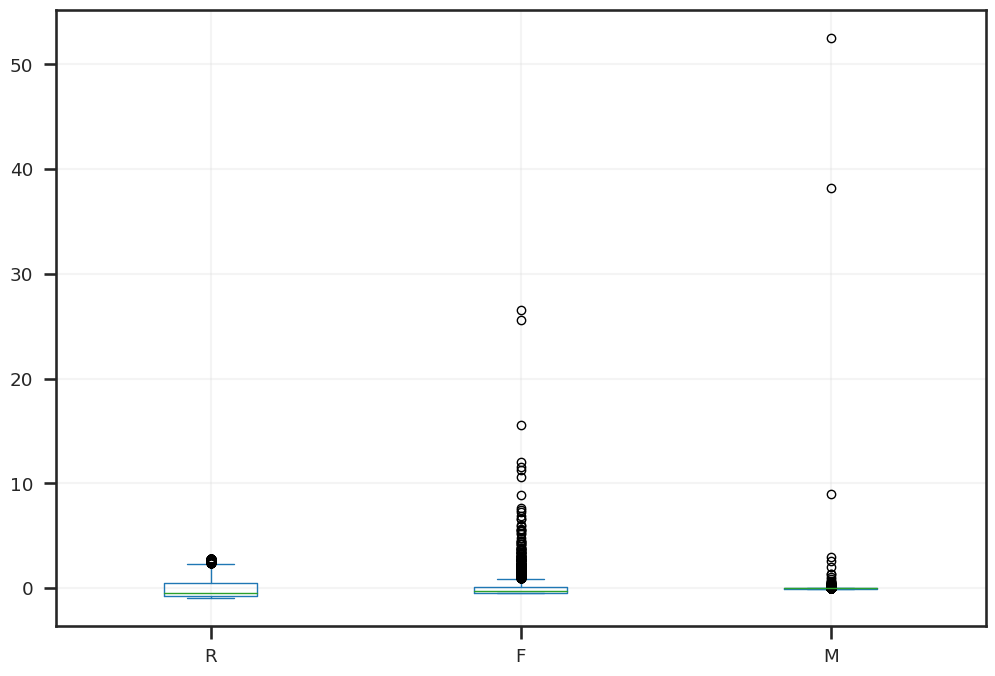

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
#Dropando outliers

df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
12346,2.329388,-0.425097,52.539782


In [ ]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [ ]:
df_rfm = df_rfm.drop(15098)

<Axes: >

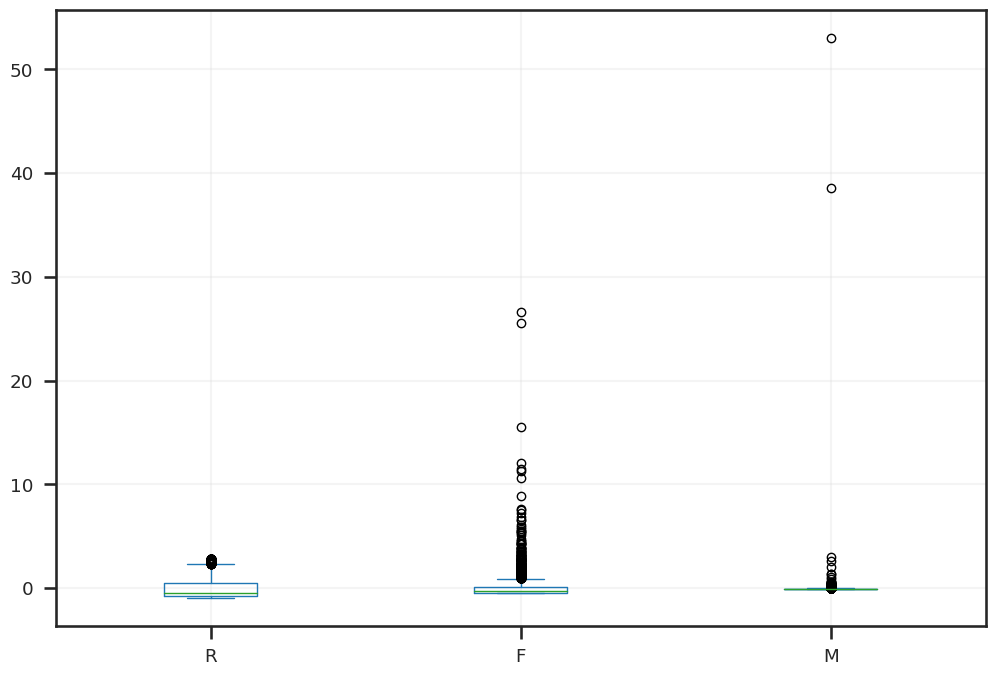

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
#Normalizando os dados, padronizando.

scaler = PowerTransformer()

In [ ]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12346,1.606634,-1.158190,3.964927
12347,-1.562469,1.202042,0.408622
12348,0.323718,0.660839,1.321118
12349,-0.808540,-1.158190,0.427521
12350,1.568148,-1.158190,0.190985
...,...,...,...
18280,1.475383,-1.158190,0.087404
18281,1.107273,-1.158190,-0.489604
18282,-1.274349,-0.195633,-0.159003


<Axes: >

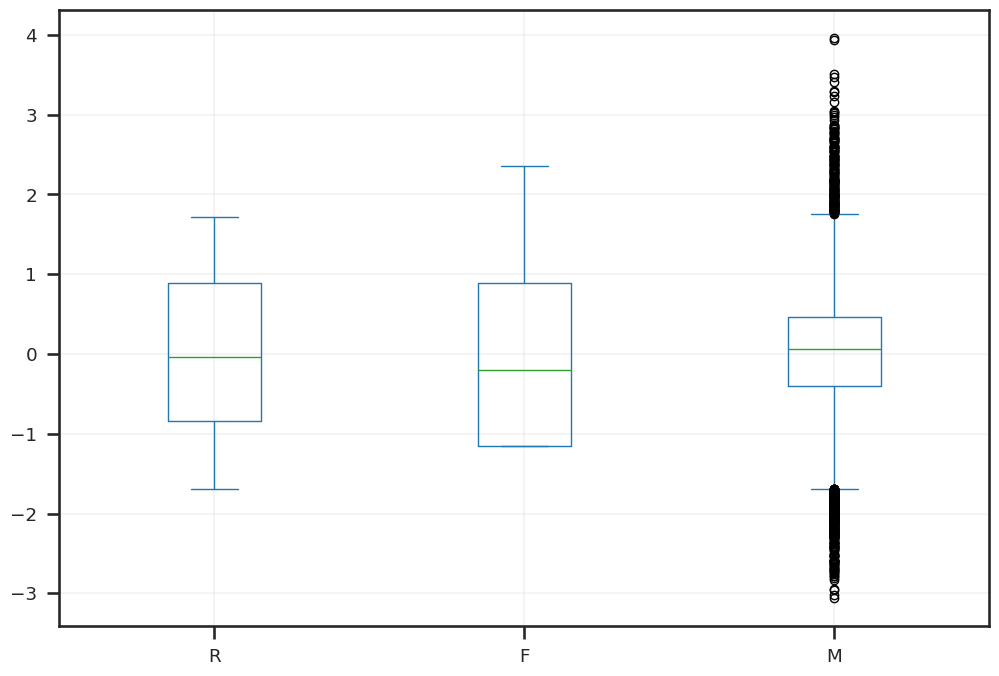

In [ ]:
df_rfm_scaled.plot.box()

In [ ]:
#Ajustando outliers

df_rfm.describe()

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,114.038736,4.272308,65.298361
std,100.014468,7.698861,1454.256687
min,22.000000,1.000000,2.101286
25%,39.000000,1.000000,12.365198
50%,72.000000,2.000000,17.719914
75%,163.000000,5.000000,24.850667
max,395.000000,209.000000,77183.600000


In [ ]:
#Normalizando valores para reduzir outliers. Colocando um clip.

df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,112.251787,3.607793,23.759723
std,95.546328,3.358701,21.327572
min,22.000000,1.000000,2.101286
25%,39.000000,1.000000,12.365198
50%,72.000000,2.000000,17.719914
75%,163.000000,5.000000,24.850667
max,333.000000,13.000000,93.525556


In [ ]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

# Etapa 03) Selecione um algoritmo de clusterização

**a. Escolha um algoritmo adequado para base de dados, como o K0Means, DBSCAN, Hierarquia ou Mean Shift**

b. Encontre a quantidade ideal de clusters através dos métodos de Elbow ou Silhouette Score **negrito**

c. Implemente o algoritmo escolhido **negrito**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

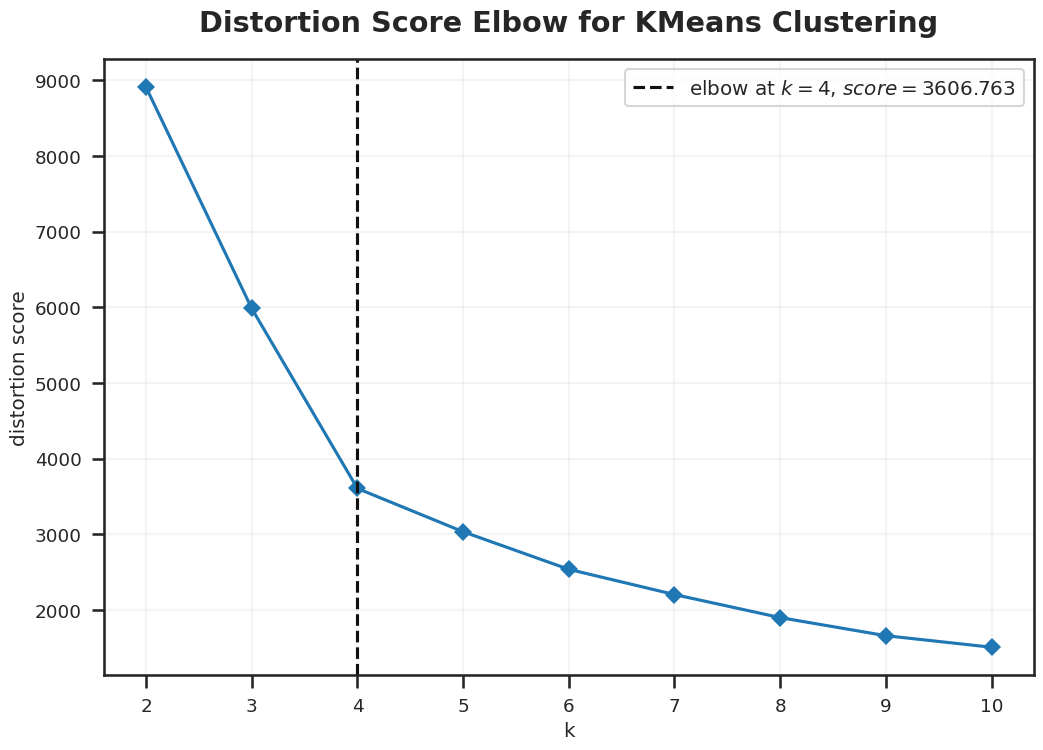

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
#Testandos os modelos e avaliando seus resultado.


# K-Means


kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8908.400648,0.383124,1.064185,1996.409011
3,5985.270212,0.434565,0.859803,2543.704112
4,3606.771701,0.480345,0.702747,3765.939835
5,3035.255913,0.485673,0.738051,3559.416169
6,2538.528748,0.398293,0.849854,3573.433946
7,2205.229475,0.377237,0.868638,3536.216675
8,1902.049759,0.384603,0.863081,3611.948935
9,1661.512232,0.395259,0.800988,3695.472571
10,1512.279227,0.352160,0.890321,3655.627428


# Montando - Recencia, Frequencia e Valor (RFV)




In [ ]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

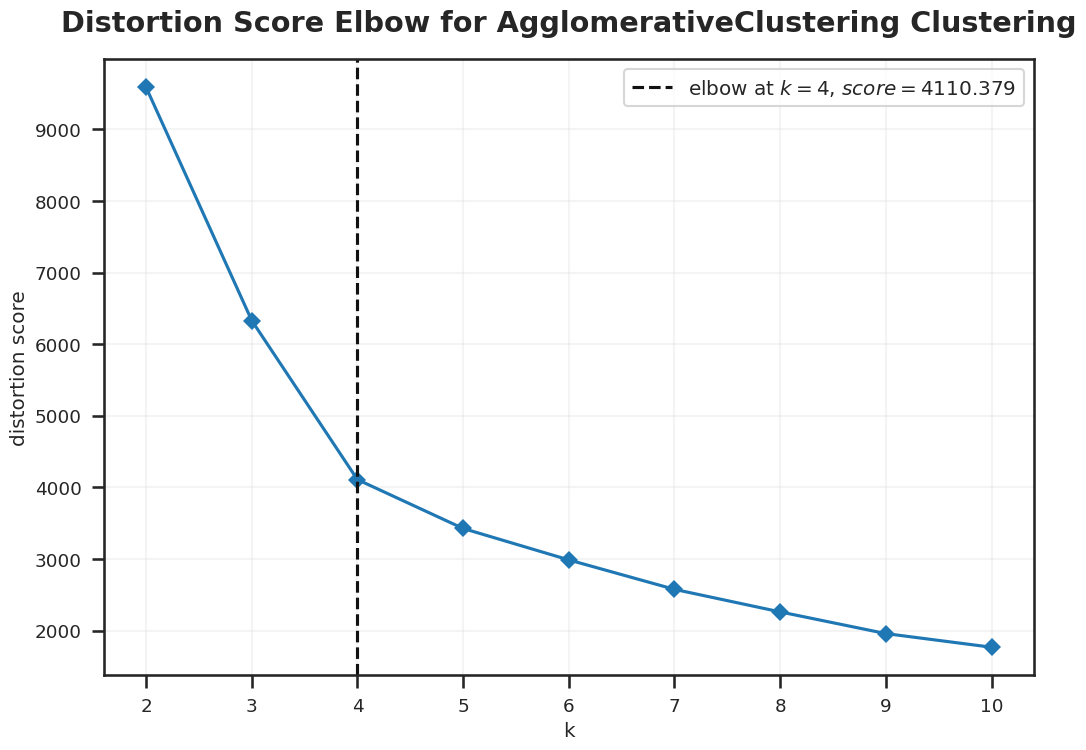

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
# Hierarchical Clustering

kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.328036,1.009574,1547.845991
3,0.407630,0.953979,2286.375557
4,0.427889,0.852793,3127.561076
5,0.437710,0.771245,3027.281541
6,0.406462,0.764082,2903.891659
7,0.407790,0.853103,2920.328165
8,0.355563,0.912297,2936.468138
9,0.365636,0.821974,3049.122510
10,0.280344,0.951601,3052.682857


In [ ]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

In [ ]:
# Gaussian Mixture

# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()


,bic,n_components,covariance_type
28,-265.218324,8,full
30,-191.636795,8,diag
26,111.509176,7,diag
24,121.192238,7,full
20,9295.680504,6,full


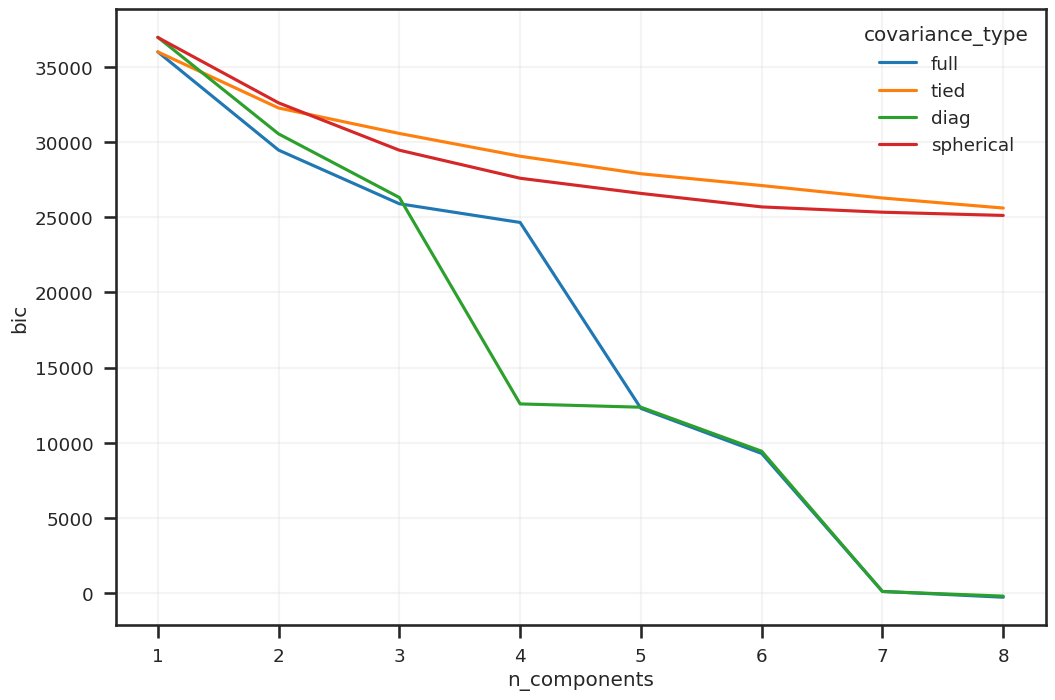

In [ ]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');


In [ ]:
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

# *Para seguir com a analise utilizaremos o modelo Kmeans, pois nos permitirá uma análise melhor apurada, pelo tamanho do cojunto de dados.*

**Etapa 04) Analise os clusters obtidos**

**a. Identifique os padrões e características em comum entre os clientes**

**b. Plote gráficos para auxiliar na análise**

In [ ]:
df_rfm_clip_scaled

,R,F,M
CustomerID,,,
12346,2.310645,-0.776519,3.271534
12347,-0.923761,1.010092,-0.003677
12348,-0.159646,0.116787,1.604482
12349,-0.756284,-0.776519,0.014832
12350,2.300178,-0.776519,-0.191752
...,...,...,...
18280,1.954756,-0.776519,-0.267277
18281,0.939425,-0.776519,-0.572752
18282,-0.871424,-0.478750,-0.418390


In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

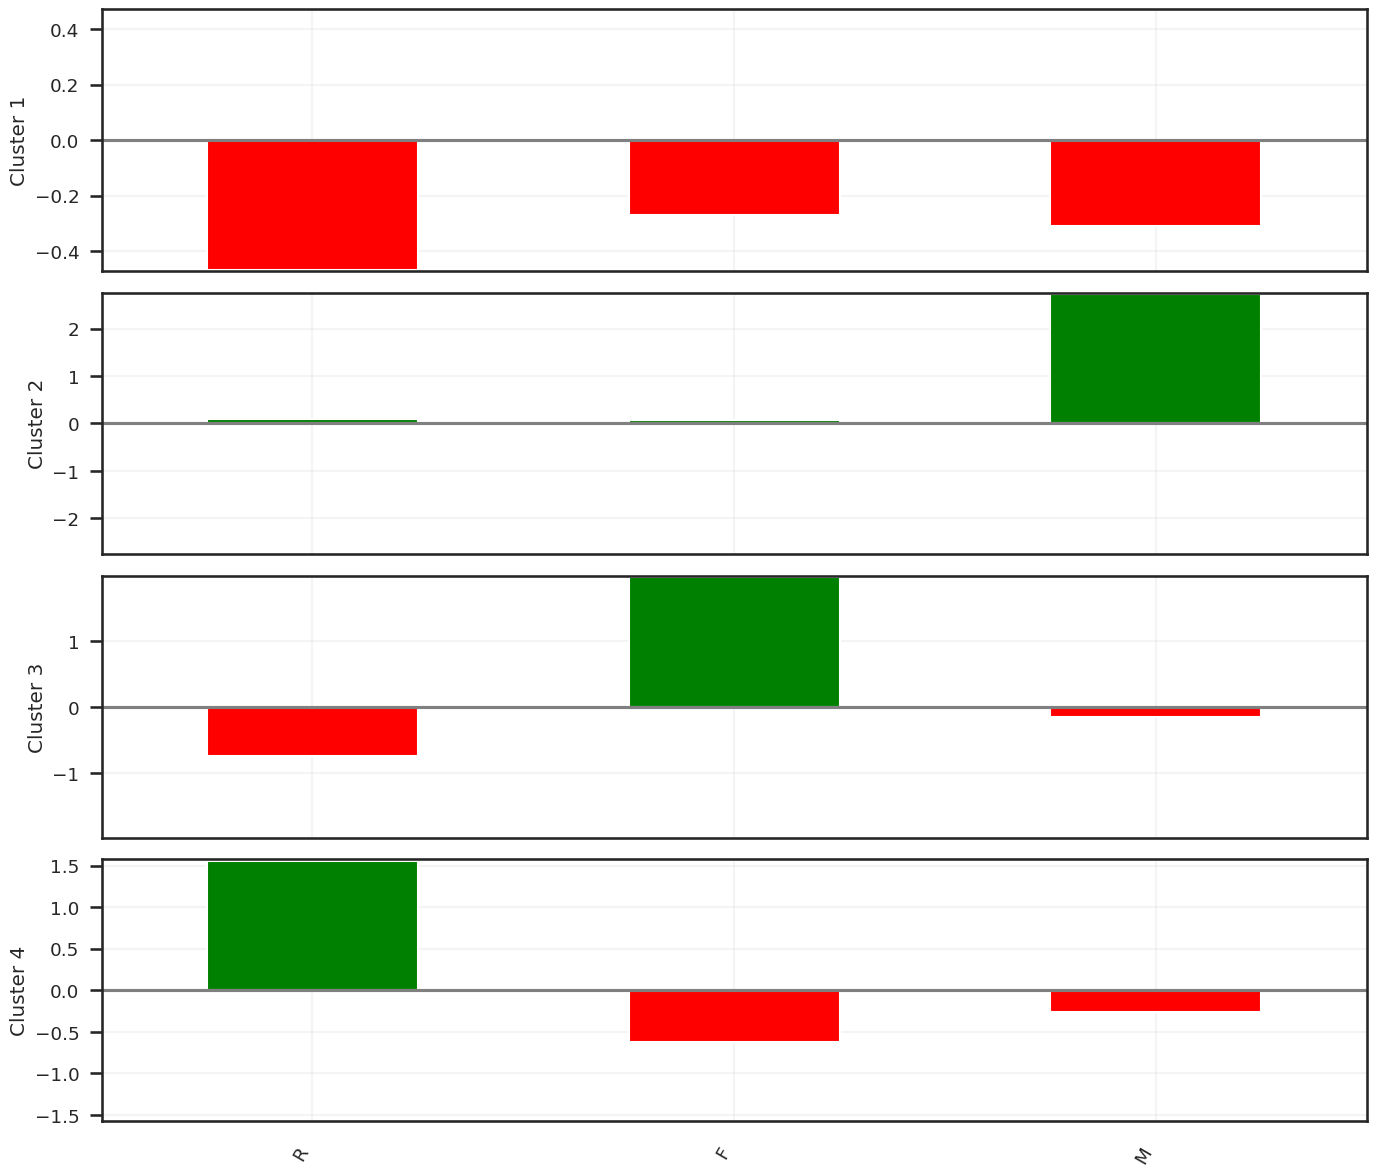

In [ ]:
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,67.567660,121.152672,41.522654,261.043033
F,2.701702,3.882952,10.192557,1.509221
M,17.163318,82.128840,20.506865,18.199021


In [ ]:
#Importando mais bibliotecas necessárias
from sklearn.cluster import DBSCAN
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import dbscan



In [ ]:
#Clusterização com DBSCAN


df_rfm_clip_scaled

,R,F,M
CustomerID,,,
12346,2.310645,-0.776519,3.271534
12347,-0.923761,1.010092,-0.003677
12348,-0.159646,0.116787,1.604482
12349,-0.756284,-0.776519,0.014832
12350,2.300178,-0.776519,-0.191752
...,...,...,...
18280,1.954756,-0.776519,-0.267277
18281,0.939425,-0.776519,-0.572752
18282,-0.871424,-0.478750,-0.418390


# Alternativa de Clusterização DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()
df_rfm_clip_scaled = scaler.fit_transform(df_rfm_clip[['R', 'F', 'M']])

# Criando o modelo DBSCAN com eps ajustado para controlar densidade
modeloDB = DBSCAN(eps=0.33, min_samples=10)

# Ajustando o modelo e obtendo os rótulos
labels_dbscan = modeloDB.fit_predict(df_rfm_clip_scaled)

# Criando o gráfico 3D
fig = px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=labels_dbscan.astype(str), template='plotly_dark')
fig.show()

In [ ]:
(
  df_rfm_clip.assign(cluster=labels_dbscan)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,-1,0,1,2,3
R,133.283843,146.828571,109.575406,32.536585,326.307692
F,5.537118,2.165714,3.471255,12.707317,1.076923
M,56.968387,93.141438,17.752673,93.151000,78.353499


# Etapa 05) Interpretação dos resultados obtidos




**OBS.: O modelo escolhido pela melhor performance foi o KMeans e esse será utilizado para auxílio na tomada de decisão deste projeto.**

a. Descreva o perfil de compras dos clientes de cada cluster

b. Justifique como essa análise pode ser útil para empresa para segmentação de seus clientes e personalização das campanhas de marketing

c. Sugira ações possíveis com base nas ações realizadas



**Essa análise de clusters utilizando RFM (Recência, Frequência, Monetariedade) fornece uma visão estruturada e segmentada do comportamento e tipos dos clientes. Esses clusters podem (e devem)ser utilizados para segmentar a base de clientes, permitindo uma compreensão mais aprofundada dos diferentes perfis de clientes. Isso é valioso para a personalização de campanhas de marketing, pois a empresa pode adaptar suas estratégias para atender às necessidades específicas de cada segmento**

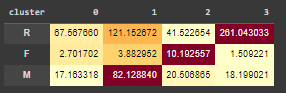


Clusters Obtidos:



*Cluster* 0:

Características: Recência moderada (67.52), baixa frequência (2.70), valor monetário moderado (17.16). Sugestões de Ações: Lançar campanhas promocionais para incentivar compras adicionais. Implementar programas de recompensas para aumentar a frequência de compras.

Cluster 1:

Características: Alta recência (121.15), baixa frequência (3.88), alto valor monetário (82.12). Sugestões de Ações: Implementar estratégias de retenção para manter clientes leais. Oferecer programas de fidelidade ou exclusividade para incentivar compras frequentes


Cluster 2:

Características: Baixa recência (261.04), baixa frequência (1.50), valor monetário relativamente alto (18.19). Sugestões de Ações: Desenvolver estratégias de reativação para reconquistar clientes inativos. Oferecer promoções especiais ou descontos para incentivar a retomada das compras.

Cluster 3:

Características: Recência moderada (41.52), alta frequência (10.19), valor monetário moderado (20.50). Sugestões de Ações: Direcionar campanhas para aumentar ainda mais a frequência de compras. Oferecer ofertas exclusivas para incentivar gastos adicionais. Essa